In [28]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*pJ3o_2zTTNnixhKH.png' />

## Loading the Dataset

In [6]:

BATCH_SIZE = 32

# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((227, 227)), transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.CIFAR10(root='CIFAR10_data', train=True, transform=transforms, download=True)
valid_dataset = datasets.CIFAR10(root='CIFAR10_data', train=False, transform=transforms, download=True)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10_data/cifar-10-python.tar.gz to CIFAR10_data
Files already downloaded and verified


# Plotting the Images

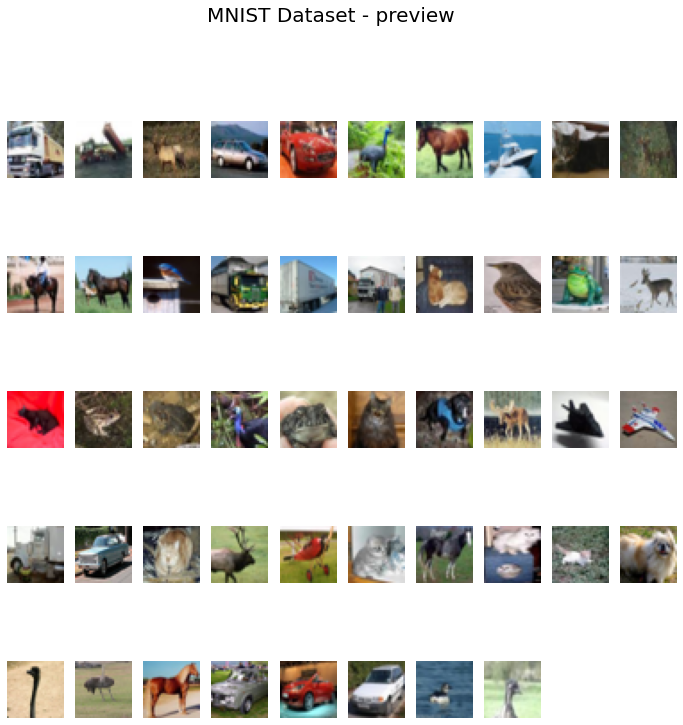

In [27]:

N_COLS = 10
N_ROWS = 5

fig = plt.figure(figsize=(12,12))
for index in range(1, N_COLS*N_ROWS - 1):
  plt.subplot(N_ROWS, N_COLS, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview', fontsize=20);

# AlexNet Model

In [29]:
from torch.nn.modules.container import Sequential
class AlexNet(nn.Module):
    def __init__(self, NUM_CLASSES=10):
        super(AlexNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96,kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=4, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=9216, out_features=4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=NUM_CLASSES))
        

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(x)
        out = self.layer3(x)
        out = self.layer4(x)
        out = self.layer5(x)
        out = out.reshape(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        logits = self.fc3(out)
        probs = F.softmax(logits, dim=1)
        return logits, probs

# Train Loop

In [30]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0


    with torch.no_grad():
        model.eval()
        for X,y_true in data_loader:

          X = X.to(device)
          y_true = y_true.to(device)

          _, y_prob = model(X)
          _, predicted_labels = torch.max(y_prob,1)

          n += y_true.size(0)
          correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))
    ax.plot(train_losses, color='blue', label= 'Training loss')
    ax.plot(valid_losses, color='red', label= 'Validation loss')
    ax.set(title='Loss over epochs',
           xlabel='Epoch',
           ylabel='Loss')
    plt.legend()
    plt.show()

    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model,criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    
    model.train()    
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()           # Sets the gradients of all optimized torch.Tensor s to zero.

        X = X.to(device)
        y_true = y_true.to(device)

        # forward paas
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item()*X.size(0)        # X.size() ----> Returns the size of the self tensor

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
      
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader,epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []


    # Train model
    for epoch in range(0,epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model,criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every -1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

# Setting Hyperparameters

In [35]:
NUM_EPOCHS = 10
NUM_CLASSES = 10
LEARNING_RATE = 0.001

model = AlexNet(NUM_CLASSES=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.005)


x = torch.randn(100,3,227,227)
x = x.to(device)
output,_ = model(x)
print(output.shape)
summary(model, (3,227,227))

RuntimeError: ignored

# Evaluating the predictions

In [ ]:
N_COLS = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1,  N_COLS* N_ROWS + 1):
    plt.subplot(N_ROWS, N_COLS, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')

    with torch.no_grad():
        model.eval()
        _,probs = model(valid_dataset[index][0].unsqueeze(0))

    title = f'{torch.argmax(probs)}  ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');
     